# Brain Tumor Detection Using YOLOv8

In this study, object detection was performed using the YOLOv8 model with a brain tumor image dataset. Despite the dataset consisting of only 800 images and using the smallest YOLO model, Nano, successful results were achieved.

### Table of Contents

1. [Data Exploration](#data-exploration)

2. [YOLOv8 Detector Model Training](#yolov8-detector-model-training)  
   2.1. [Checking for Corrupt Images](#checking-for-corrupt-images)  
   2.2. [Splitting the Dataset into Train, Validation, and Test Sets](#splitting-the-dataset-into-train-validation-and-test-sets)  
   2.3. [Training](#training)  
   2.4. [Training Results](#training-results)  
   2.5. [Brain Tumor Detection / Prediction](#brain-tumor-detection-prediction)



In [54]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\msa29\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [55]:
import os
import yaml
from os.path import exists
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import shutil
import glob
import logging
from tqdm import tqdm
from itertools import compress
from typing import Optional, List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cv2
import imutils
import ultralytics
from ultralytics import YOLO


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))
ultralytics.checks()

Ultralytics 8.3.204  Python-3.11.9 torch-2.8.0+cpu CPU (Intel Core i5-8250U 1.60GHz)
Setup complete  (8 CPUs, 15.9 GB RAM, 102.2/176.8 GB disk)


## 1. Data Exploration

In [56]:
# Primary dataset path
primary_path = r"dataset/brain-tumor-dataset"
# Fallback dataset path
fallback_path = r"Brain_Tumor_Detection_Using_YOLO/dataset/brain-tumor-dataset"

# Use primary path if it exists, otherwise use fallback
brain_tumor_dataset_directory = primary_path if os.path.exists(primary_path) else fallback_path

print(f"Using dataset path: {brain_tumor_dataset_directory}")

Using dataset path: dataset/brain-tumor-dataset


In [57]:
def df_from_image_folders(images_path: str, extension: Optional[str] = "jpg") -> pd.DataFrame:
    """
    Create a DataFrame from image files in specified directories.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories of images.
    extension : str, optional
        The file extension of the images to include (default is "png").

    Returns
    -------
    pd.DataFrame
        A DataFrame with two columns: 'path' containing file paths and 'label' containing the class labels.
    """
    
    label = []
    path = []
    image_files = glob.glob(os.path.join(images_path, "**", f"*.{extension.lower()}"), recursive=True)

    for file in image_files:
        dirpath = os.path.dirname(file)
        folder_name = os.path.basename(dirpath)
        label.append(folder_name)
        path.append(file)

    class_dict = {"path": path, "label": label}
    return pd.DataFrame(class_dict)

In [58]:
df = df_from_image_folders(brain_tumor_dataset_directory, extension = "jpg")
df.head()

,path,label
0,dataset/brain-tumor-dataset\1.jpg,brain-tumor-dataset
1,dataset/brain-tumor-dataset\10.jpg,brain-tumor-dataset
2,dataset/brain-tumor-dataset\100.jpg,brain-tumor-dataset
3,dataset/brain-tumor-dataset\101.jpg,brain-tumor-dataset
4,dataset/brain-tumor-dataset\102.jpg,brain-tumor-dataset


**Total images count**

In [59]:
df.shape

(801, 2)

In [60]:
def display_images(df: pd.DataFrame, img_width: int = 224) -> None:
    """
    Displays three images from the DataFrame side by side.
    """
    
    # Check if DataFrame has enough rows
    if len(df) < 3:
        print(f"Error: DataFrame only has {len(df)} rows. Need at least 3 images.")
        return
    
    plt.figure(figsize=(15, 6))  # Adjust the size for better visual
    
    # Display three images side by side
    for i in range(3):
        image_path = df.iloc[i, 0]  # Get image path
        img = cv2.imread(image_path)
        img = imutils.resize(img, width=img_width)
        
        plt.subplot(1, 3, i + 1)  # 1 row, 3 columns
        plt.imshow(img)
        plt.axis('off')

    plt.show()


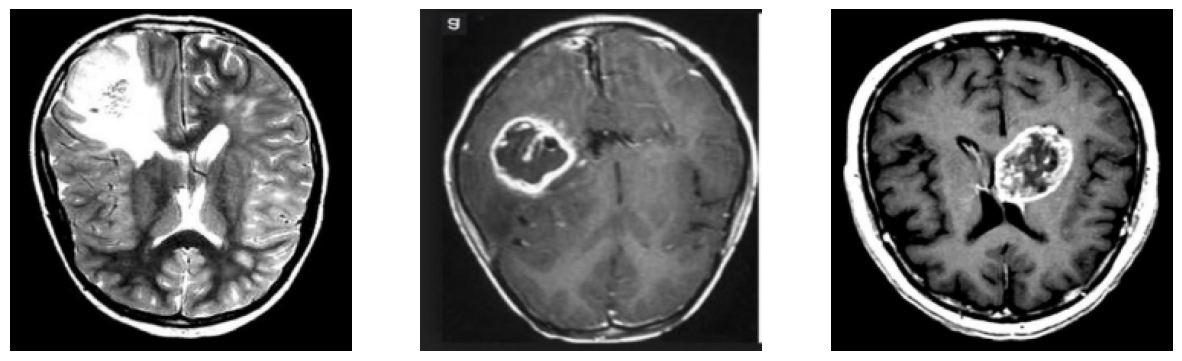

In [61]:
display_images(df)

**Analysis of Image Sizes and Channels**

In [62]:
def process_image(image_path):
    """
    Loads an image using OpenCV and extracts its width, height, and number of channels.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        tuple: (width, height, channels) if successful, otherwise None.
    """
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
        
        if image is None:
            return None  
        
        height, width = image.shape[:2]
        channels = image.shape[2] if len(image.shape) == 3 else 1  
        return width, height, channels  

    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None  

def compute_image_statistics_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes image statistics (average width, height, and channels) for each class using parallel processing.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'path' and 'label' columns.

    Returns:
        pd.DataFrame: A DataFrame containing average and min/max statistics for each class.
    """
    stats = []
    grouped = df.groupby('label')

    for label, group in grouped:
        image_paths = group['path'].tolist()

        widths, heights, channel_counts = [], [], []

        # ThreadPoolExecutor for parallel execution
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(process_image, image_paths))

        results = [res for res in results if res is not None]

        if results:
            widths, heights, channel_counts = zip(*results)

            stats.append({
                'Fish Class': label,
                'Average Width': np.mean(widths),
                'Average Height': np.mean(heights),
                'Average Channels': np.mean(channel_counts),
                'Min Width': np.min(widths),
                'Max Width': np.max(widths),
                'Min Height': np.min(heights),
                'Max Height': np.max(heights)
            })

    return pd.DataFrame(stats)

In [63]:
df_statistics = compute_image_statistics_from_df(df)
df_statistics

,Fish Class,Average Width,Average Height,Average Channels,Min Width,Max Width,Min Height,Max Height
0,brain-tumor-dataset,640.0,640.0,1.0,640,640,640,640


 ## 2. YOLOv8 Detector Model Training

 ### 2.1 Checking for Corrupt Images
 
 If a corrupted file is found, it is moved to the "corrupt_images" folder.

In [64]:
def move_image(path_file: str, dest_folder: str) -> None:
    """
    Moves a corrupted image to the specified destination folder.

    If the destination folder doesn't exist, it will be created.

    Parameters:
    path_file (str): Path to the corrupted image file.
    dest_folder (str): Path to the destination folder where the corrupted image will be moved.
    """
    if not os.path.isdir(dest_folder):
        os.mkdir(dest_folder)

    try:
        shutil.move(path_file, dest_folder)
    except shutil.SameFileError:
        print("Source and destination represent the same file.")

def check_image(source_folder: str, dest_folder: str, file: str, corrupted_files: list) -> None:
    """
    Checks for corrupted images in the specified folder.

    If a corrupted image is detected, it is moved to the destination folder.

    Parameters:
    source_folder (str): Path to the folder containing the images.
    dest_folder (str): Path to the folder where corrupted images will be moved.
    file (str): The image file or subfolder to check for corruption.
    corrupted_files (list): A list to store paths of corrupted images that are moved.
    """
    path_folder = os.path.join(source_folder, file)
    
    if os.path.isdir(path_folder):
        for sub_file in os.listdir(path_folder):
            check_image(path_folder, dest_folder, sub_file, corrupted_files)
    else:
        if file.lower().endswith(('.jpg', '.png')):
            file_path = os.path.join(source_folder, file)
            img = cv2.imdecode(np.fromfile(file_path, np.uint8), cv2.IMREAD_COLOR)
            
            if img is None:
                print(f"Corrupted image detected: {file_path}")
                move_image(file_path, dest_folder)
                corrupted_files.append(file_path)

def process_images(source_folder: str, dest_folder: str) -> None:
    """
    Processes all images in the source folder to detect and move corrupted images.

    If corrupted images are found, they are moved to the destination folder. 
    After processing, a message is displayed indicating whether corrupted images were found.

    Parameters:
    source_folder (str): Path to the folder containing images to be checked.
    dest_folder (str): Path to the folder where corrupted images will be moved.
    """
    corrupted_files = []
    with ThreadPoolExecutor() as executor:
        futures = []
        for file in os.listdir(source_folder):
            futures.append(executor.submit(check_image, source_folder, dest_folder, file, corrupted_files))

        for future in tqdm(futures, desc="Processing images"):
            future.result()
    
    if corrupted_files:
        print(f"Corrupted images have been moved to the destination folder: {dest_folder}")
    else:
        print("No corrupted images found.")

In [65]:
source_folder = brain_tumor_dataset_directory.replace('\\', '/') # Use the variable with fallback and replace backslashes with forward slashes
dest_folder = r"corrupt_images"

process_images(source_folder, dest_folder)

Processing images: 100%|██████████| 1602/1602 [00:00<00:00, 3479.63it/s]

No corrupted images found.


### 2.2 Splitting the Dataset into Train, Validation, and Test Sets

10% of the dataset was allocated for validation and another 10% for testing. The validation set was used during model training, while the test set was reserved for evaluating the model's performance after training was completed.

In [66]:
def get_difference_from_2_list(list1: List[int], list2: List[int]) -> List[int]:
    """
    Returns the elements in list1 that are not in list2.

    Parameters:
    - list1 (List[int]): The first list of integers.
    - list2 (List[int]): The second list of integers.

    Returns:
    - List[int]: The difference between list1 and list2.
    """
    return list(set(list1) - set(list2))


def get_split_data(list_id: List[int], train_percentage: float, validation_percentage: float, test_percentage: float) -> Tuple[List[int], List[int], List[int]]:
    """
    Splits the dataset into training, validation, and testing sets based on the given percentages.

    Parameters:
    - list_id (List[int]): List of indices corresponding to the dataset items.
    - train_percentage (float): The percentage of data to be used for training.
    - validation_percentage (float): The percentage of data to be used for validation.
    - test_percentage (float): The percentage of data to be used for testing.

    Returns:
    - Tuple[List[int], List[int], List[int]]: Lists of indices for training, validation, and testing datasets.
    """
    total = len(list_id)
    n_train = int((train_percentage / 100) * total)
    train = random.sample(list_id, n_train)

    list_id = get_difference_from_2_list(list_id, train)

    n_valid = int((validation_percentage / 100) * total)
    valid = random.sample(list_id, n_valid)

    test = get_difference_from_2_list(list_id, valid)

    return train, valid, test


def make_folders(destination_folder: str) -> None:
    """
    Creates the necessary directories for storing images and labels.

    Parameters:
    - destination_folder (str): The base directory where 'images' and 'labels' folders will be created.
    
    Returns:
    - None: Creates directories but does not return anything.
    """
    folders = ["images", "labels"]
    inner_folders = ["train", "val", "test"]

    if not os.path.isdir(destination_folder):
        os.mkdir(destination_folder)

    for folder in folders:
        path = os.path.join(destination_folder, folder)
        if not os.path.isdir(path):
            os.mkdir(path)

        for in_folder in inner_folders:
            inner_path = os.path.join(path, in_folder)
            if not os.path.isdir(inner_path):
                os.mkdir(inner_path)


def copy_image(file: str, source_folder: str, destination_folder: str, id_folder: int) -> None:
    """
    Copies the image and its corresponding label to the appropriate directory based on the split (train, validation, test).

    Parameters:
    - file (str): The image filename (e.g., "image.jpg").
    - source_folder (str): The source directory where the original images and labels are located.
    - destination_folder (str): The base directory where the 'images' and 'labels' folders are located.
    - id_folder (int): The index corresponding to the split (0 for train, 1 for validation, 2 for test).

    Returns:
    - None: Copies the image and label files, but does not return anything.
    """
    inner_folders = ["train", "val", "test"]

    # Copy image
    source = os.path.join(source_folder, file)
    destination = os.path.join(destination_folder, 'images', inner_folders[id_folder], file)
    try:
        shutil.copy(source, destination)
    except shutil.SameFileError:
        print(f"Source and destination represent the same file: {file}")

    # Copy label
    separator = file.find(".")
    filename = file[:separator] + ".txt"
    source = os.path.join(source_folder, filename)
    destination = os.path.join(destination_folder, 'labels', inner_folders[id_folder], filename)
    try:
        shutil.copy(source, destination)
    except shutil.SameFileError:
        print(f"Source and destination represent the same file: {filename}")


def copy_files_parallel(files: List[str], source_folder: str, destination_folder: str, id_folder: int) -> None:
    """
    Copies the files in parallel to the appropriate directories (train, validation, test) using ThreadPoolExecutor.

    Parameters:
    - files (List[str]): List of filenames (e.g., ["image1.jpg", "image2.jpg"]).
    - source_folder (str): The source directory where the original images and labels are located.
    - destination_folder (str): The base directory where the 'images' and 'labels' folders are located.
    - id_folder (int): The index corresponding to the split (0 for train, 1 for validation, 2 for test).

    Returns:
    - None: Copies the files in parallel but does not return anything.
    """
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(copy_image, file, source_folder, destination_folder, id_folder) for file in files]
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Copying files to {['train', 'val', 'test'][id_folder]}"):
            future.result()  


def split_and_copy_dataset(source_folder: str, destination_folder: str, train_percentage: float, validation_percentage: float, test_percentage: float) -> pd.DataFrame:
    """
    Splits the dataset into training, validation, and testing sets and copies the corresponding files to the respective directories.
    Returns a DataFrame with counts of images and labels in each set.

    Parameters:
    - source_folder (str): The directory where the original dataset is located (both images and labels).
    - destination_folder (str): The base directory where the 'images' and 'labels' folders will be created.
    - train_percentage (float): The percentage of data to be used for training.
    - validation_percentage (float): The percentage of data to be used for validation.
    - test_percentage (float): The percentage of data to be used for testing.

    Returns:
    - pd.DataFrame: A DataFrame containing counts of images and labels in each set (train, validation, test).
    """
    # Validate the percentages
    if train_percentage < validation_percentage or train_percentage < test_percentage:
        print("Train set must have the biggest percentage.")
        return pd.DataFrame()

    total_percentage = train_percentage + validation_percentage + test_percentage
    if total_percentage != 100:
        print("Total percentage must be 100%.")
        return pd.DataFrame()

    # Prepare dataset
    list_id = [count for count, file in enumerate(os.listdir(source_folder)) if file.endswith((".jpg", ".png"))]
    train, valid, test = get_split_data(list_id, train_percentage, validation_percentage, test_percentage)

    # Create necessary folders
    make_folders(destination_folder)

    # Create file lists for each split
    train_files = [file for count, file in enumerate(os.listdir(source_folder)) if count in train]
    valid_files = [file for count, file in enumerate(os.listdir(source_folder)) if count in valid]
    test_files = [file for count, file in enumerate(os.listdir(source_folder)) if count in test]

    # Copy files in parallel
    print("Copying train files...")
    copy_files_parallel(train_files, source_folder, destination_folder, 0)
    print("Copying validation files...")
    copy_files_parallel(valid_files, source_folder, destination_folder, 1)
    print("Copying test files...")
    copy_files_parallel(test_files, source_folder, destination_folder, 2)

    # Create DataFrame with counts of images and labels
    data = {
        "Set": ["Train", "Validation", "Test"],
        "Images Count": [len(train_files), len(valid_files), len(test_files)],
        "Labels Count": [len(train_files), len(valid_files), len(test_files)]
    }
    df = pd.DataFrame(data)

    print("Dataset splitting and copying completed.")
    return df

In [67]:
source_folder = brain_tumor_dataset_directory  # Use the variable with fallback
destination = r"brain-tumor-dataset-splitted"

df = split_and_copy_dataset(source_folder, destination, 80, 10, 10)
df.head()

Copying train files...


Copying files to train: 100%|██████████| 640/640 [00:00<00:00, 1061.45it/s]


Copying validation files...


Copying files to val: 100%|██████████| 80/80 [00:00<00:00, 1286.72it/s]


Copying test files...


Copying files to test: 100%|██████████| 81/81 [00:00<00:00, 1287.38it/s]

Dataset splitting and copying completed.


,Set,Images Count,Labels Count
0,Train,640,640
1,Validation,80,80
2,Test,81,81


### 2.3 Training

In [68]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"PyTorch version: {torch.__version__}")

CUDA available: False
CUDA device: None
PyTorch version: 2.8.0+cpu


In [69]:
config_data = {
    "path": r"brain-tumor-dataset-splitted",
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": ["Tumor"]
}

with open('config.yaml', 'w') as f:
    yaml.dump(config_data, f, default_flow_style=None, sort_keys=False)

data_path = 'config.yaml'

In [70]:
model = YOLO("yolov8n.pt")

model.train(
    data=data_path,
    epochs=100,
    patience=10,
    batch=16,
    imgsz=640,
    device=0,
    optimizer="AdamW",
    lr0=0.01,
    lrf=0.01,
    warmup_epochs=3,
    save=True,
    cache=True,
    amp=True,
    resume=False,
    project="brain_tumor_project",
    name="yolov8_object_detection",
)

New https://pypi.org/project/ultralytics/8.3.207 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.204  Python-3.11.9 torch-2.8.0+cpu 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 0
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


### 2.4 Training Results

The training process has progressed stably, with losses decreasing while mAP and recall values increase, indicating good generalization. The early stabilization of validation losses suggests a low risk of overfitting, while the mAP50-95 reaching around 0.6 indicates a reasonable accuracy. A recall of 0.8 shows that the model detects objects at a high rate, though minor fluctuations could be further reduced with hyperparameter tuning. However, since only 800 images and the smallest YOLO Nano model were used, the results may be limited. Higher accuracy could be achieved by using a larger model and expanding the dataset.

True


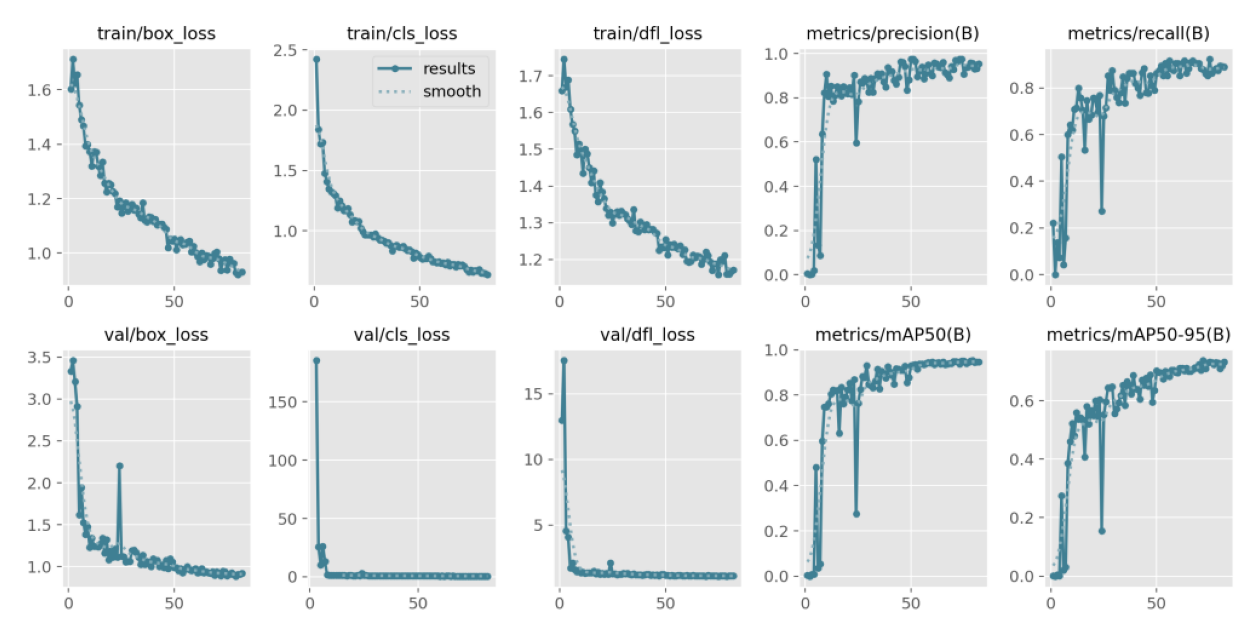

In [ ]:
img_path = r"brain_tumor_project/yolov8_object_detection/results.png"
print(os.path.exists(img_path))
img = cv2.imread(img_path)
img = imutils.resize(img, width=1024)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 16))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

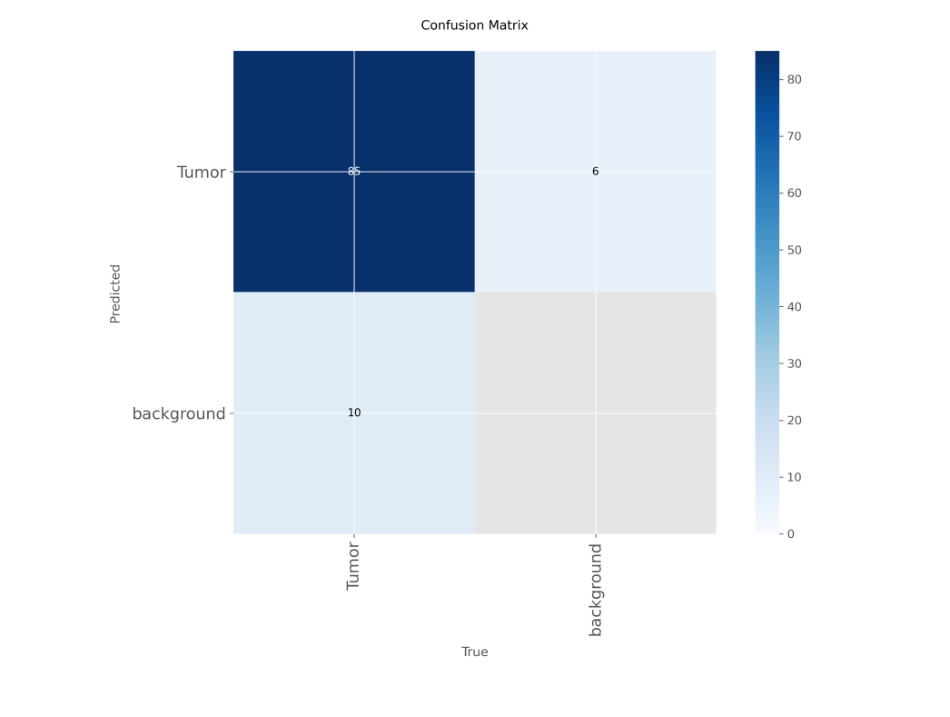

In [ ]:
img_path = r"brain_tumor_project/yolov8_object_detection/confusion_matrix.png"

img = cv2.imread(img_path)
img = imutils.resize(img, width=1024)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

### 2.5 Brain Tumor Detection / Prediction

TThe model has been successfully detecting brain tumors, as shown below.

In [ ]:
def detect_tumor_from_test_set(test_path: str, model_path: str, threshold: float = 0.5,
                               img_width: int = 360, num_samples: int = 5) -> None:
    font = cv2.FONT_HERSHEY_SIMPLEX
    model = YOLO(model_path)

    # If it's a single image file
    if os.path.isfile(test_path):
        image_files = [os.path.basename(test_path)]
        test_dir = os.path.dirname(test_path)
        num_samples = 1
    else:
        test_dir = test_path
        image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(image_files) < num_samples:
            raise ValueError(f"Not enough images in the test set. Found {len(image_files)}, but {num_samples} are required.")
        
    selected_images = random.sample(image_files, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 4, 4))
    if num_samples == 1:
        axes = [axes]

    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path)
        img = imutils.resize(img, width=img_width)
        results = model(img)[0]

        for result in results.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = result
            if score > threshold:
                x1, y1, x2, y2, class_id = int(x1), int(y1), int(x2), int(y2), int(class_id)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                class_name = results.names[class_id]
                text = f"{class_name}: %{score * 100:.2f}"
                cv2.putText(img, text, (x1, y1 - 10), font, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].axis("off")
        
        # If detections found, show probability of highest score
        if len(results.boxes) > 0:
            best_score = max([score for _, _, _, _, score, _ in results.boxes.data.tolist()])
            axes[i].set_xlabel(f"Prob: {best_score:.2%}", fontsize=9, color="green")
        else:
            axes[i].set_xlabel("No tumor detected", fontsize=9, color="red")
        
        axes[i].set_title(img_name, fontsize=10)

        

    plt.tight_layout()
    plt.show()


In [71]:
# Primary paths (local Windows)
test_image_path_local = r"brain-tumor-dataset-splitted\images\test"
model_path_local = r"brain_tumor_project\yolov8_object_detection\weights\best.pt"

# Fallback paths (Colab/remote with forward slashes)
test_image_path_remote = r"brain-tumor-dataset-splitted/images/test"
model_path_remote = r"brain_tumor_project/yolov8_object_detection/weights/best.pt"

# Use local path if it exists, otherwise use remote path
test_image_path = test_image_path_local if os.path.exists(test_image_path_local) else test_image_path_remote
model_path = model_path_local if os.path.exists(model_path_local) else model_path_remote

print(f"Using test image path: {test_image_path}")
print(f"Using model path: {model_path}")

detect_tumor_from_test_set(test_image_path, model_path)

Using test image path: brain-tumor-dataset-splitted\images\test
Using model path: brain_tumor_project/yolov8_object_detection/weights/best.pt


NameError: name 'detect_tumor_from_test_set' is not defined

In [ ]:
!yolo task=detect mode=val model="brain_tumor_project/yolov8_object_detection/weights/best.pt" data="config.yaml"

Ultralytics 8.3.187 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1197.8±409.8 MB/s, size: 51.0 KB)
val: Scanning /kaggle/working/brain-tumor-dataset-splitted/labels/val.cache... 80 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 80/80 1111073.9it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 3.7it/s 1.3s
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
                   all         80         95      0.965       0.88      0.946      0.738
Speed: 3.7ms preprocess, 2.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to r